In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import datetime as dt
plt.rcParams["figure.figsize"] = (18, 6)

In [2]:
ba_users = pd.read_csv('generated/new_ba_users.csv')
ba_reviews = pd.read_parquet('generated/new_ba_reviews.parquet')

rb_users = pd.read_csv('generated/new_rb_users.csv')
rb_reviews = pd.read_parquet('generated/new_rb_reviews.parquet')

In [3]:
ba_users['joined'].head()

0    2008-01-07
1    2007-10-08
2    2005-05-18
3    2004-11-25
4    2003-11-20
Name: joined, dtype: object

# Task - User activity : What can we say about the activity of reviewers

## Data preparation

In [4]:
ba_users['user_id'] = ba_users['user_id'].astype(str)
rb_users['user_id'] = rb_users['user_id'].astype(str)
ba_reviews['user_id'] = ba_reviews['user_id'].astype(str)
rb_reviews['user_id'] = rb_reviews['user_id'].astype(str)

ba_users['joined'] = pd.to_datetime(ba_users['joined'])
rb_users['joined'] = pd.to_datetime(rb_users['joined'])
ba_reviews['date'] = pd.to_datetime(ba_reviews['date'])
rb_reviews['date'] = pd.to_datetime(rb_reviews['date'])

ba_reviews_per_user = ba_reviews.groupby('user_id')
rb_reviews_per_user = rb_reviews.groupby('user_id')

In [5]:
ba_unique_users = ba_reviews['user_id'].unique()
ba_users_from_reviews = pd.DataFrame(ba_unique_users, columns=['user_id'])

ba_users_from_reviews['platform'] = 'BeerAdvocate'

ba_users_from_reviews = ba_users_from_reviews.merge(ba_users[['user_id','joined']], on='user_id', how='left')
ba_users_from_reviews = ba_users_from_reviews.loc[~ba_users_from_reviews.user_id.duplicated()]
ba_users_from_reviews.set_index('user_id', inplace=True)

In [6]:
rb_unique_users = rb_reviews['user_id'].unique()
rb_users_from_reviews = pd.DataFrame(rb_unique_users, columns=['user_id'])

rb_users_from_reviews['platform'] = 'RateBeer'

rb_users_from_reviews = rb_users_from_reviews.merge(rb_users[['user_id','joined']], on='user_id', how='left')
rb_users_from_reviews = rb_users_from_reviews.loc[~rb_users_from_reviews.user_id.duplicated()]
rb_users_from_reviews.set_index('user_id', inplace=True)

## Features definition
1) total number of reviews
2) time since registration
3) diversity of beer styles
4) consistency (engagement habits) : frequency mean
5) consistency (engagement habits) : frequency std

In [7]:
# 1. total nb of reviews
ba_users_from_reviews['total_reviews'] = ba_reviews_per_user['beer_id'].count()

rb_users_from_reviews['total_reviews'] = rb_reviews_per_user['beer_id'].count()


In [8]:
# 2. time since registration (until last activity recorded)
ba_users_from_reviews['last_review'] = ba_users_from_reviews['joined'].max()
ba_users_from_reviews['usage_duration'] = (ba_users_from_reviews['last_review'] - ba_users_from_reviews['joined']).dt.days
ba_users_from_reviews.drop(columns='last_review', inplace=True)

rb_users_from_reviews['last_review'] = rb_users_from_reviews['joined'].max()
rb_users_from_reviews['usage_duration'] = (rb_users_from_reviews['last_review'] - rb_users_from_reviews['joined']).dt.days
rb_users_from_reviews.drop(columns='last_review', inplace=True)

In [9]:
# 3. style diversity
ba_users_from_reviews['style_diversity'] = ba_reviews_per_user['style'].nunique()

rb_users_from_reviews['style_diversity'] = rb_reviews_per_user['style'].nunique()

In [10]:
# 4.-5. consistency
ba_reviews_sorted = ba_reviews[['user_id','date']].copy()
ba_reviews_sorted.set_index('user_id',inplace=True)
ba_reviews_sorted.sort_values('date', inplace=True)

ba_time_spacings = ba_reviews_sorted.groupby('user_id')['date'].apply(lambda x : x.diff().dt.days).dropna()
ba_users_from_reviews['mean_time_spacing'] = (
    ba_time_spacings.groupby('user_id').mean()
)
ba_users_from_reviews['std_time_spacing'] = (
    ba_time_spacings.groupby('user_id').std()
)

rb_reviews_sorted = rb_reviews[['user_id','date']].copy()
rb_reviews_sorted.set_index('user_id',inplace=True)
rb_reviews_sorted.sort_values('date', inplace=True)

rb_time_spacings = rb_reviews_sorted.groupby('user_id')['date'].apply(lambda x : x.diff().dt.days).dropna()
rb_users_from_reviews['mean_time_spacing'] = (
    rb_time_spacings.groupby('user_id').mean()
)
rb_users_from_reviews['std_time_spacing'] = (
    rb_time_spacings.groupby('user_id').std()
)

In [11]:
# Concatenate features from both platform
ba_features = ba_users_from_reviews.drop(columns=['joined'])
rb_features = rb_users_from_reviews.drop(columns=['joined'])

features = pd.concat([ba_features, rb_features])

In [12]:
features.sample(15)

,platform,total_reviews,usage_duration,style_diversity,mean_time_spacing,std_time_spacing
user_id,,,,,,
285967,RateBeer,1,1372.0,1,NaN,NaN
serengeti.42152,BeerAdvocate,20,4321.0,7,25.736842,81.516762
gauss.1076295,BeerAdvocate,21,607.0,18,10.600000,13.390492
36472,RateBeer,5,4113.0,5,21.000000,19.078784
48675,RateBeer,23,3840.0,10,3.681818,11.921914
randon.248331,BeerAdvocate,1,3247.0,1,NaN,NaN
148169,RateBeer,2,2041.0,2,0.000000,NaN
txdohawk.138191,BeerAdvocate,1,3733.0,1,NaN,NaN
100029,RateBeer,237,2755.0,53,7.025424,66.544749


## Features preprocessing : NaN values and scaling

In [13]:
nan_counts = ba_users_from_reviews.isna().sum()
print(f"NaN values in BeerAdvocate features : \n{nan_counts}\n")
nan_counts = rb_users_from_reviews.isna().sum()
print(f"NaN values in RateBeer features : \n{nan_counts}\n")

NaN values in BeerAdvocate features : 
platform                 0
joined                1278
total_reviews            0
usage_duration        1278
style_diversity          0
mean_time_spacing    23127
std_time_spacing     31407
dtype: int64

NaN values in RateBeer features : 
platform                 0
joined                  33
total_reviews            0
usage_duration          33
style_diversity          0
mean_time_spacing    28094
std_time_spacing     37313
dtype: int64



In [14]:
# Count NaN values for combines features
nan_counts = features.isna().sum()

# Display the counts
print(nan_counts)
print(f"Initial length : {len(features)}")

platform                 0
total_reviews            0
usage_duration        1311
style_diversity          0
mean_time_spacing    51221
std_time_spacing     68720
dtype: int64
Initial length : 132355


In [15]:
features_cleaned = features.drop(columns='platform').copy()
features_cleaned.dropna(inplace=True)

In [16]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_cleaned)
features_scaled = pd.DataFrame(features_scaled, columns=features_cleaned.columns, index=features_cleaned.index)

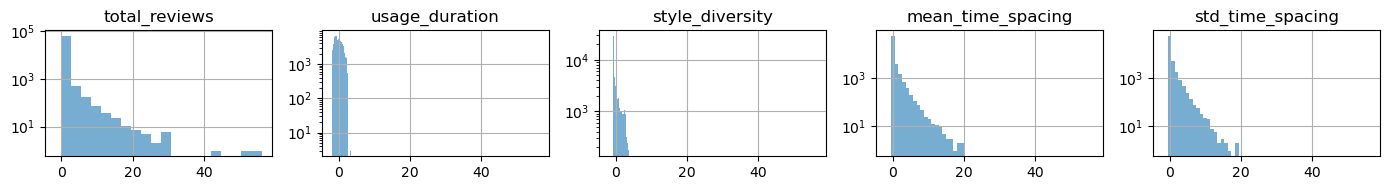

In [17]:
columns = features_scaled.columns

fig, axs = plt.subplots(1, len(columns), figsize=(14,2), sharex=True)

for column_idx in range(0, len(columns)):
    features_scaled[columns[column_idx]].hist(bins=20, ax=axs[column_idx], alpha=0.6)
    axs[column_idx].set_title(columns[column_idx])
    axs[column_idx].set_yscale('log') 
    
plt.tight_layout()

## Dimensionality reduction (PCA)

In [18]:
pca = PCA(n_components=0.95)  # Retain 95% of variance
PCs = pca.fit_transform(features_scaled)
features_reduced = pd.DataFrame(PCs, index=features_scaled.index, columns=[f"PC{i+1}" for i in range(PCs.shape[1])])
print(f"Explained variance by components: {pca.explained_variance_ratio_}\n")
print(f"Unexplained variance: {1-pca.explained_variance_ratio_.sum()}")

Explained variance by components: [0.40678313 0.30731094 0.16881693 0.09610591]

Unexplained variance: 0.02098308174416219


## Number of clusters (silhouette score + elbow method)

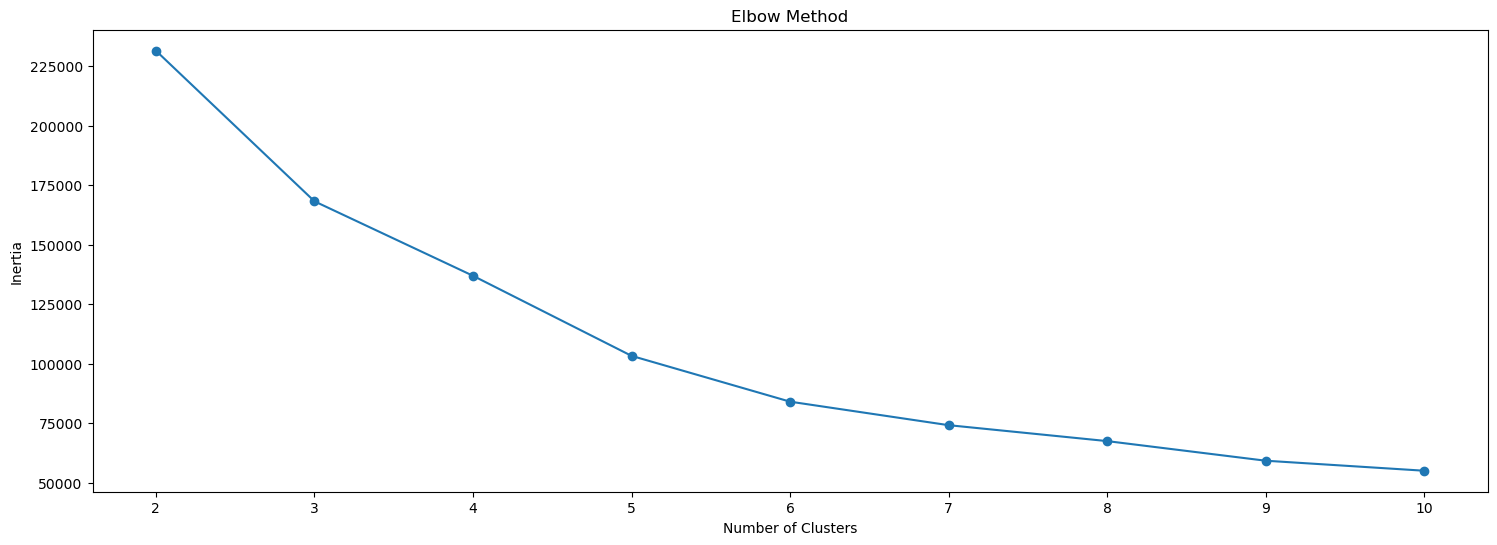

In [19]:
# Elbow Method
inertia = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_reduced)
    inertia.append(kmeans.inertia_)

plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
#for k in cluster_range:
#    kmeans = KMeans(n_clusters=k, random_state=42)
#    labels = kmeans.fit_predict(features_reduced)
#    score = silhouette_score(features_reduced, labels)
#    print(f"Silhouette Score for {k} clusters: {score}")



In [20]:
# n_clusters = 2 # doesn't make sense
n_clusters = 3

## Clustering

In [21]:
# Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_reduced)
cluster_labels_series = pd.Series(cluster_labels, index=features_reduced.index, name='cluster')

if 'cluster' not in features.columns:
    features = features.join(cluster_labels_series, how='left')
else :
    features['cluster'] = cluster_labels_series
features.head(20)

,platform,total_reviews,usage_duration,style_diversity,mean_time_spacing,std_time_spacing,cluster
user_id,,,,,,,
nmann08.184925,BeerAdvocate,465,3493.0,81,2.961207,17.926253,1.0
stjamesgate.163714,BeerAdvocate,2504,3584.0,93,1.273672,4.020508,1.0
mdagnew.19527,BeerAdvocate,1143,4457.0,87,3.503503,7.180989,1.0
helloloser12345.10867,BeerAdvocate,31,4631.0,17,43.366667,92.192633,2.0
cypressbob.3708,BeerAdvocate,604,5002.0,81,4.262023,20.940931,1.0
brewdude1982.691169,BeerAdvocate,95,1802.0,40,2.723404,6.409677,2.0
agentmunky.409755,BeerAdvocate,1990,2771.0,94,1.348919,2.711835,1.0
ferrari29.320392,BeerAdvocate,389,3029.0,74,3.760309,22.221036,1.0
othershoe2.233642,BeerAdvocate,1315,3309.0,100,2.233638,25.854288,1.0


## Evaluation and Visualization

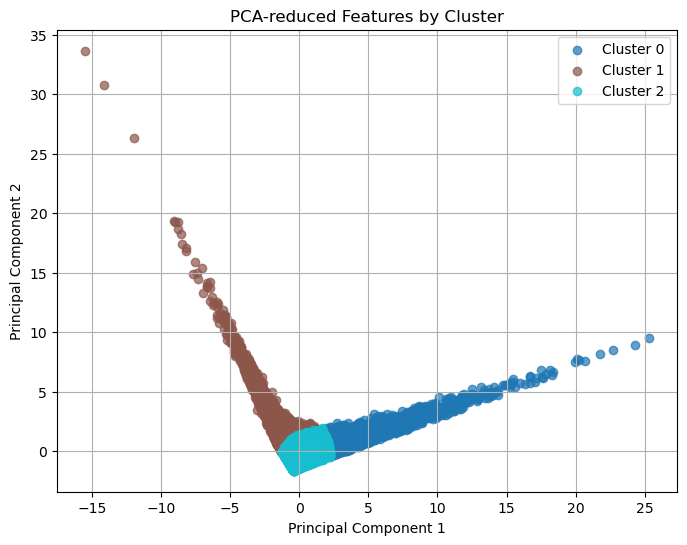

In [22]:
cluster_features_reduced = features_reduced.copy()
if 'cluster' not in cluster_features_reduced.columns:
    cluster_features_reduced = cluster_features_reduced.join(cluster_labels_series, how='left')

colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(8, 6))
for cluster_id in range(n_clusters):
    cluster_points = cluster_features_reduced[cluster_features_reduced['cluster'] == cluster_id]
    plt.scatter(
        cluster_points.iloc[:, 0], 
        cluster_points.iloc[:, 1], 
        alpha=0.7, 
        color=colors[cluster_id], 
        label=f"Cluster {cluster_id}"
    )

# Adding labels, legend, and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA-reduced Features by Cluster")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [23]:
# Pseudo-supervised : attributing values to cluster
cluster_mean = features.drop(columns='platform').groupby('cluster').mean()
experienced_cluster = cluster_mean['total_reviews'].idxmax()

print(f"The cluster with the most experienced reviewers is cluster : {experienced_cluster}")

The cluster with the most experienced reviewers is cluster : 1.0


In [24]:
print(f"Inertia: {kmeans.inertia_:.2f}")

#from sklearn.metrics import davies_bouldin_score

#db_score = davies_bouldin_score(rb_features_reduced, rb_features['cluster'].dropna().astype(int))
#print(f"Davies-Bouldin Index: {db_score:.3f}")

Inertia: 168285.19


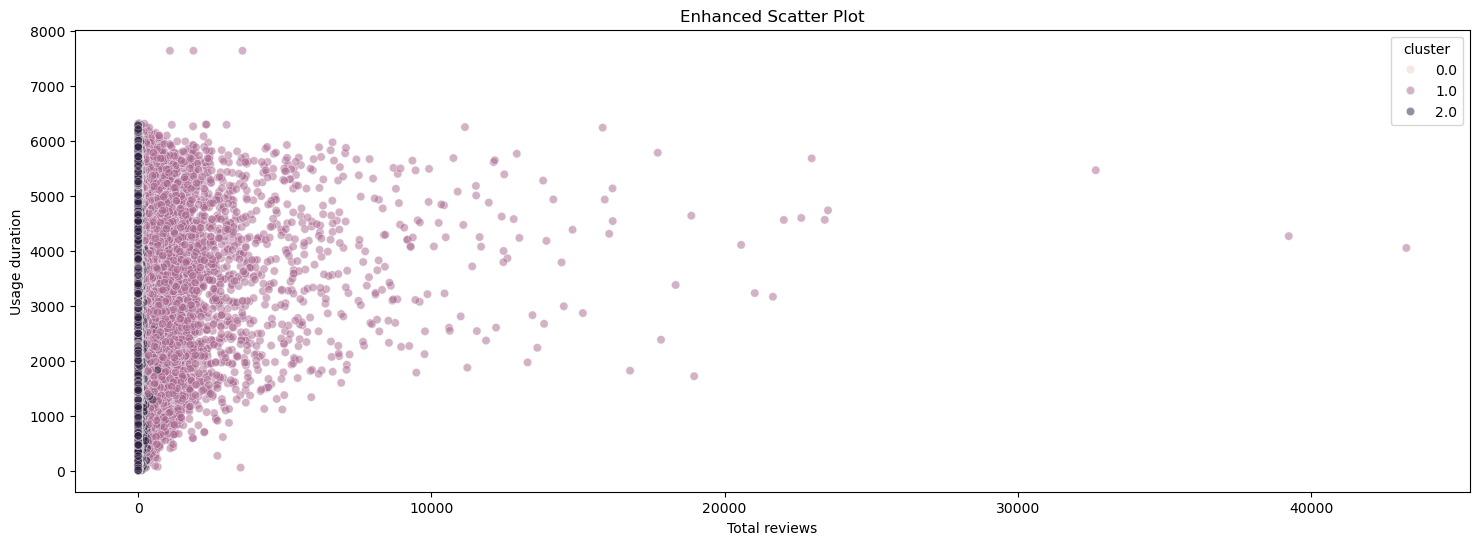

In [25]:
# Scatter plot using seaborn
sns.scatterplot(data=features, x='total_reviews', y='usage_duration', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Total reviews')
plt.ylabel('Usage duration')
plt.title('Enhanced Scatter Plot')
plt.show()

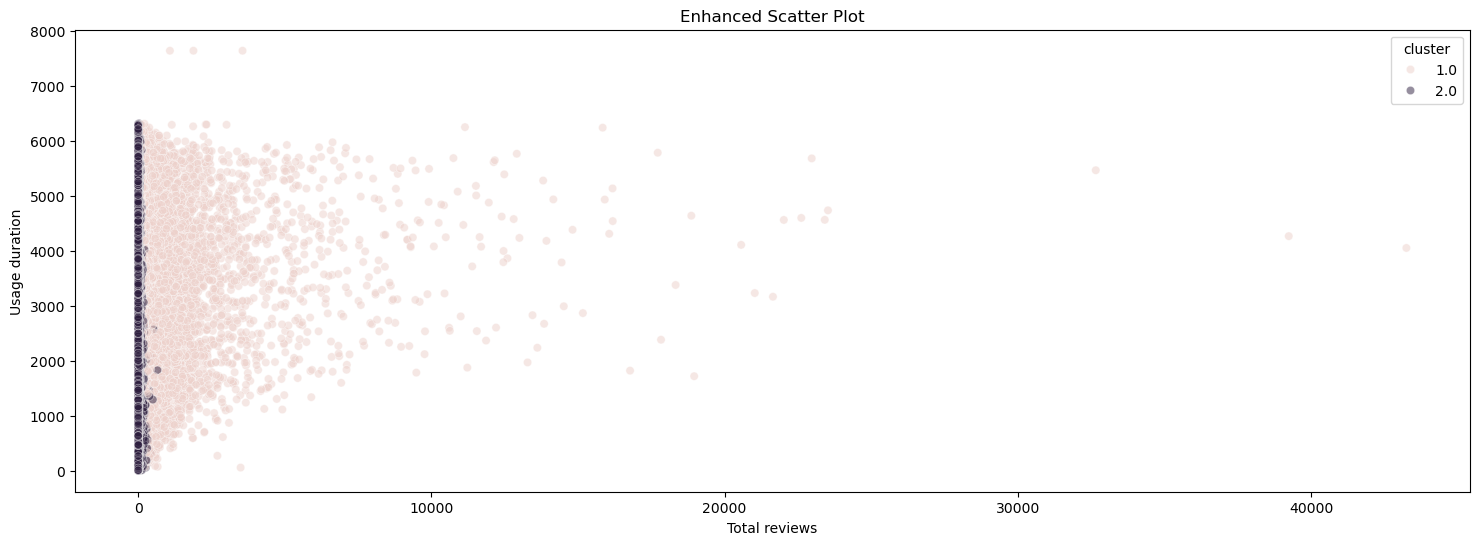

In [26]:
# Scatter plot using seaborn
sns.scatterplot(data=features[features['cluster']!=0], x='total_reviews', y='usage_duration', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Total reviews')
plt.ylabel('Usage duration')
plt.title('Enhanced Scatter Plot')
plt.show()

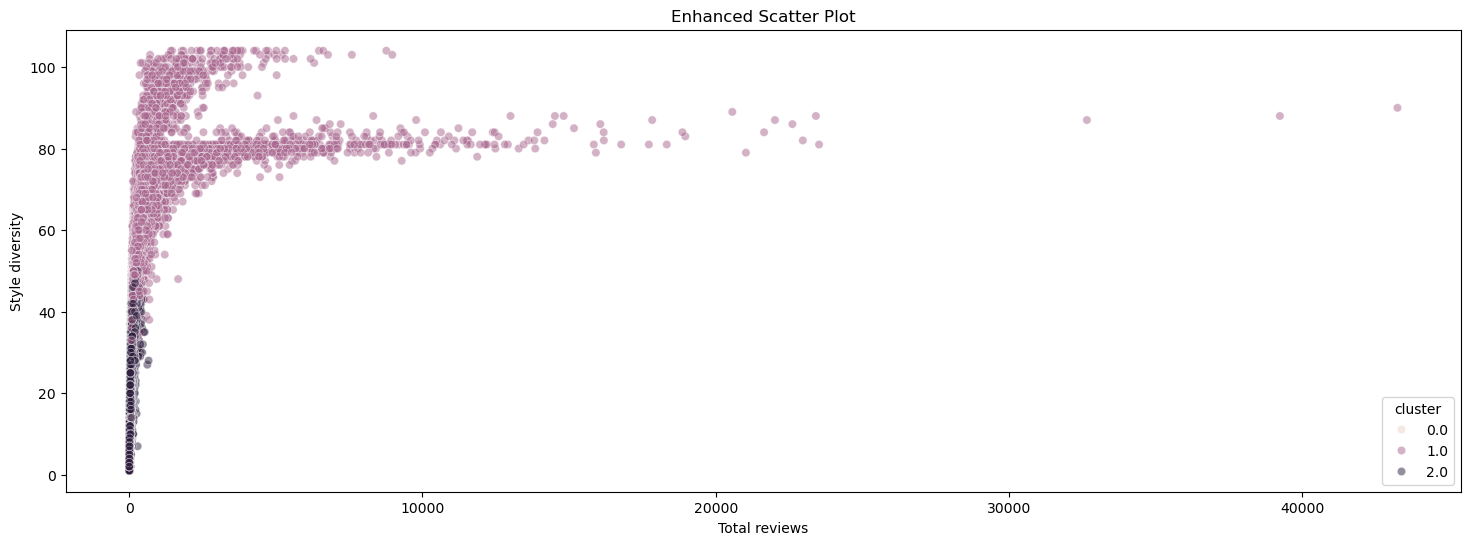

In [27]:
# Scatter plot using seaborn
sns.scatterplot(data=features, x='total_reviews', y='style_diversity', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Total reviews')
plt.ylabel('Style diversity')
plt.title('Enhanced Scatter Plot')
plt.show()

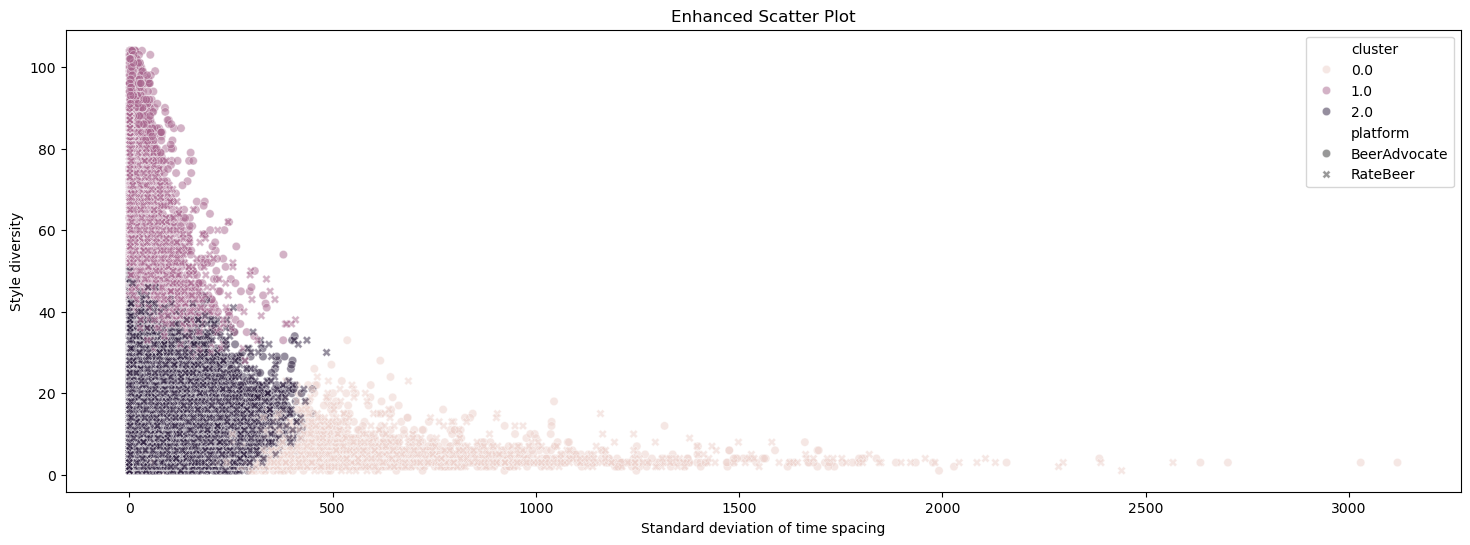

In [28]:
# Scatter plot using seaborn
sns.scatterplot(data=features, x='std_time_spacing', y='style_diversity', hue='cluster', style='platform', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Standard deviation of time spacing')
plt.ylabel('Style diversity')
plt.title('Enhanced Scatter Plot')
plt.show()

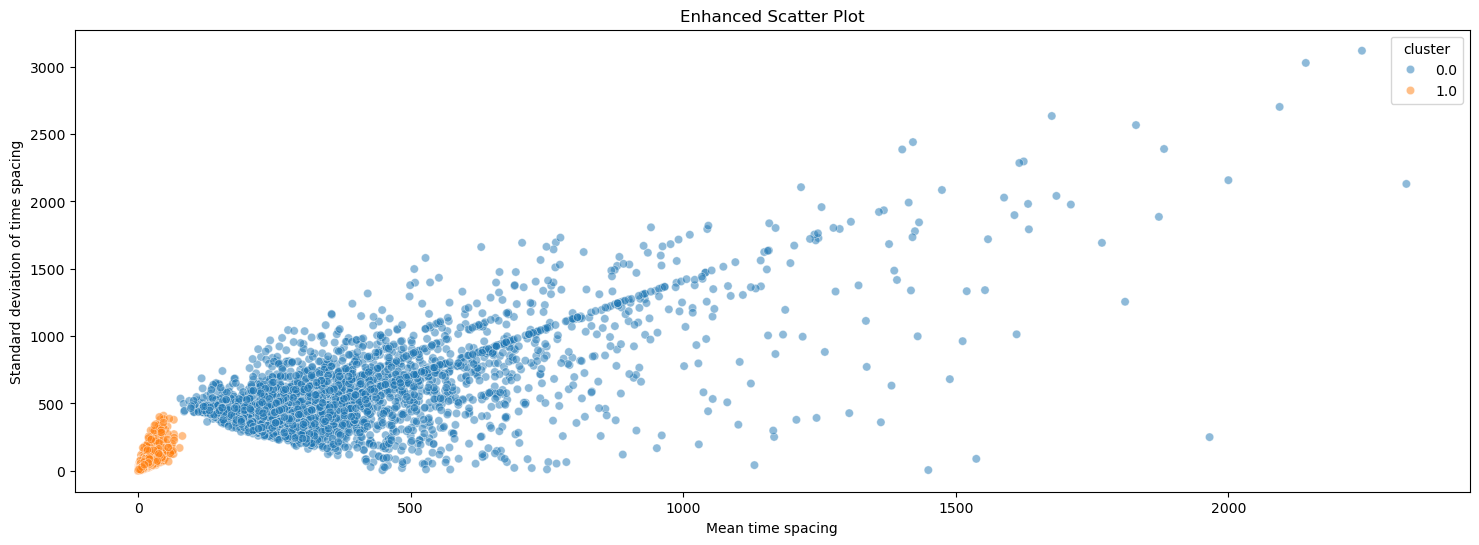

In [29]:
# Scatter plot using seaborn
sns.scatterplot(data=features[features['cluster']!=2], x='mean_time_spacing', y='std_time_spacing', hue='cluster', alpha=0.5)

# Optional: Customize labels and title
plt.xlabel('Mean time spacing')
plt.ylabel('Standard deviation of time spacing')
plt.title('Enhanced Scatter Plot')
plt.show()

## Analysis

In [30]:
cluster_summary = features.drop(columns='platform').groupby('cluster').agg(['mean','median','std','min','max'])
cluster_summary

total_reviews                                usage_duration          \
                 mean median          std min    max           mean  median   
cluster                                                                       
0.0          6.330746    5.0     4.989740   3     65    3214.682562  3232.0   
1.0        902.258119  360.0  1803.743860  43  43251    3410.184462  3483.0   
2.0         20.307426    8.0    32.728331   3    660    2280.985694  2032.0   

                                     ... mean_time_spacing              \
                 std    min     max  ...              mean      median   
cluster                              ...                                 
0.0      1193.957722  592.0  6284.0  ...        398.048391  327.000000   
1.0      1367.337571   57.0  7647.0  ...          6.429388    3.757840   
2.0      1368.931859    0.0  6318.0  ...         31.490673   11.297084   

                                        std_time_spacing              \
                std        min      max             mean      median   
cluster                                                                
0.0      246.599888  77.625000  2326.50       565.281111  479.551097   
1.0        7.725059   0.011429    81.04        27.594471   13.342250   
2.0       46.384011   0.000000   429.00        52.789091   20.163480   

                                            
                std       min          max  
cluster                                     
0.0      317.019284  4.242641  3119.755119  
1.0       38.631366  0.106597   408.853382  
2.0       72.683731  0.000000   485.314109  

[3 rows x 25 columns]

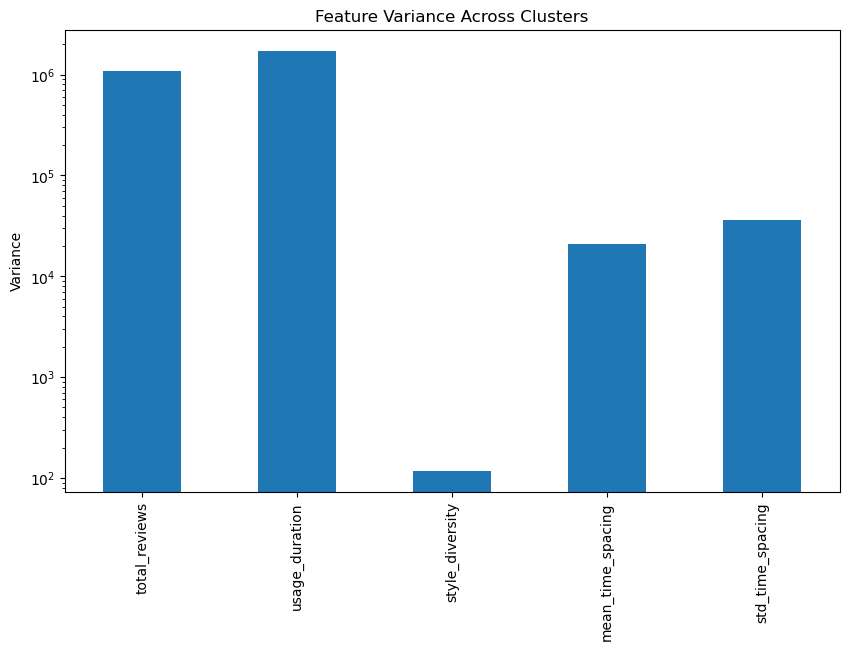

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0.0,3607.0,6.330746,4.989740,3.0,3.0,5.0,7.0,65.0
1.0,9422.0,902.258119,1803.743860,43.0,180.0,360.0,857.0,43251.0
2.0,49768.0,20.307426,32.728331,3.0,4.0,8.0,21.0,660.0


In [31]:
feature_variance = features.drop(columns='platform').groupby('cluster').var().mean()

feature_variance.plot(kind='bar', figsize=(10, 6), title='Feature Variance Across Clusters')
plt.ylabel('Variance')
plt.yscale('log')
plt.show()

features.groupby('cluster')['total_reviews'].describe()

In [32]:
features.groupby(['platform']).size()

platform
BeerAdvocate    62252
RateBeer        70103
dtype: int64

**Analysis** : RateBeer has more reviewers with more than 2 reviews than BeerAdvocate

In [33]:
# How many for each platform in cluster 0, 1 and 2
features.groupby(['platform','cluster']).size()


platform      cluster
BeerAdvocate  0.0         2308
              1.0         4055
              2.0        23663
RateBeer      0.0         1299
              1.0         5367
              2.0        26105
dtype: int64

**Analysis** : RateBeer has more active/experienced users than BeerAdvocate

**Analysis** : The cluster 0 is considered as the more active and thus, corresponding to experienced reviewers. The cluster 2 is considered as the less reviewers.

In [34]:
features_experienced = features[features['cluster']==experienced_cluster]
#experienced_users = features_experienced.index
features_experienced

,platform,total_reviews,usage_duration,style_diversity,mean_time_spacing,std_time_spacing,cluster
user_id,,,,,,,
nmann08.184925,BeerAdvocate,465,3493.0,81,2.961207,17.926253,1.0
stjamesgate.163714,BeerAdvocate,2504,3584.0,93,1.273672,4.020508,1.0
mdagnew.19527,BeerAdvocate,1143,4457.0,87,3.503503,7.180989,1.0
cypressbob.3708,BeerAdvocate,604,5002.0,81,4.262023,20.940931,1.0
agentmunky.409755,BeerAdvocate,1990,2771.0,94,1.348919,2.711835,1.0
...,...,...,...,...,...,...,...
35741,RateBeer,88,4131.0,36,6.218391,27.029452,1.0
210148,RateBeer,341,1816.0,45,4.908824,5.840095,1.0
14181,RateBeer,100,4745.0,38,7.303030,28.070412,1.0


In [37]:
# Export experienced reviewers
final_users = features_experienced.drop(columns=['cluster'])
final_users.reset_index().to_csv("exp_user.csv", index=False)